Populating the interactive namespace from numpy and matplotlib


C:\Users\Dizotoff\Anaconda3\envs\py36\lib\site-packages\IPython\core\magics\pylab.py:160: UserWarning: pylab import has clobbered these variables: ['median', 'sum', 'shuffle']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


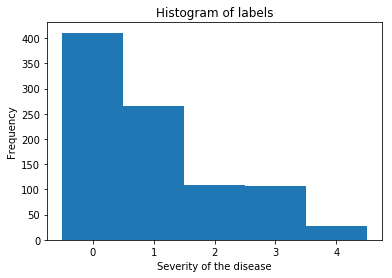

Shape of data and one-hot-labels: (920, 13) (920, 5)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_116 (Dense)            (None, 9)                 126       
_________________________________________________________________
dropout_7 (Dropout)          (None, 9)                 0         
_________________________________________________________________
dense_117 (Dense)            (None, 5)                 50        
Total params: 176
Trainable params: 176
Non-trainable params: 0
_________________________________________________________________
Elapsed time: 84.73 seconds


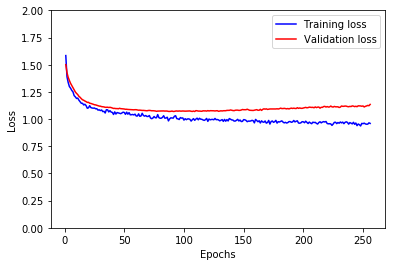

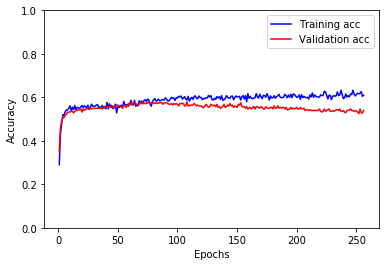

Simple guess accuracy: 0.4467
Confusion matrix:
[[411   0   0   0   0]
 [265   0   0   0   0]
 [109   0   0   0   0]
 [107   0   0   0   0]
 [ 28   0   0   0   0]]
 
Total accuracy: 0.6033
Confusion matrix:
[[353  53   1   4   0]
 [ 76 175   2  12   0]
 [ 23  67   2  17   0]
 [ 13  68   1  25   0]
 [  2  17   0   9   0]]


In [113]:
# Import libraries
%pylab inline
import time
import warnings
import pandas as pd

from sklearn.utils import shuffle
from sklearn.preprocessing import normalize
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support

from keras.utils import to_categorical
from keras import models, layers
from keras.callbacks import TensorBoard

# Import data
#First, lets try to improve perfomance with the additional data
#Using additional 3 datasets
url1 = r'http://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.hungarian.data'
df1 = pd.read_csv(url1, sep = ',', header = None, index_col = None,na_values = '?')

url2 = r'http://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.switzerland.data'
df2 = pd.read_csv(url2, sep = ',', header = None, index_col = None,na_values = '?')

url3 = r'http://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.va.data'
df3 = pd.read_csv(url3, sep = ',', header = None, index_col = None,na_values = '?')

url = r'http://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data'
df = pd.read_csv(url, sep = ',', header = None, index_col = None,na_values = '?')

#Adding them together + columns names
dataframe = pd.concat([df, df1, df2, df3], ignore_index=True)


# Add column names
name_list = ['age', 'sex', 'cp','trestbps', 'chol', 'fbs','restecg',
             'thalac','exang','oldpeak','slope','ca','thal','num']
dataframe.columns = name_list
df.columns = name_list

median = df["ca"].mean()
dataframe["ca"] = dataframe["ca"].fillna(median)

counter=0
sum=0
for c in dataframe["chol"]:
    if (c==0):
        counter=counter+1
  
for b in dataframe["chol"]:
    sum=sum+b

new_mean = sum/(len(dataframe["chol"])-counter)
dataframe.loc[dataframe.chol == 0,'chol'] = new_mean
  
dataframe.loc[dataframe.oldpeak < 0,'oldpeak'] = 0



# Fill missing data with columnwise median values
dataframe = dataframe.fillna(dataframe.median())

# Randomize rows
dataframe = shuffle(dataframe)
dataframe.tail()

# Check the descriptive statistics
dataframe.describe()

# Select the data (input) columns
data_list = ['age', 'sex', 'cp','trestbps', 'chol', 'fbs','restecg',
             'thalac','exang','oldpeak','slope','ca','thal']
data = dataframe[data_list]

# Scale the data
data_min = data.min()
data_max = data.max()
data_norm = (data - data_min)/(data_max - data_min)

# Check descriptive statistics of normalized data
data_norm.describe()

# Select labels (output)
labels = dataframe['num']

# Plot the histogram of the labels (severity of the disease)
plt.hist(labels, bins = [-0.5, 0.5, 1.5, 2.5, 3.5, 4.5])
plt.xlabel('Severity of the disease')
plt.ylabel('Frequency')
plt.title('Histogram of labels')
show()

# Code labels to categorical output
one_hot_labels = to_categorical(labels)
one_hot_labels[:5]

# Check the shapes of the normalized data and categorical output
print('Shape of data and one-hot-labels:', data_norm.shape, one_hot_labels.shape)

# Split the data and labels into training and validation sets
train_data = data_norm[:640]
val_data = data_norm[640:]

train_labels = one_hot_labels[:640]
val_labels = one_hot_labels[640:]

# Build the model
model = models.Sequential()
model.add(layers.Dense(9, activation='relu', input_shape=(13,)))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(5, activation='softmax'))
model.summary()

# Compile the model
model.compile(optimizer = 'adam',
                loss = 'categorical_crossentropy',
                metrics = ['accuracy'])

# Fit the model with the data and keep record on elapsed time
t_start = time.time()
history = model.fit(train_data, train_labels, 
                    epochs = 256, 
                    batch_size = 5, 
                    verbose = 0,
                    validation_data = (val_data, val_labels))
t_end = time.time()
print('Elapsed time: {:.2f} seconds'.format(t_end - t_start))

# Get the training data
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
acc_values = history_dict['acc']
val_acc_values = history_dict['val_acc']
epochs = range(1, len(loss_values) + 1)

# Visualize the training process: loss function
plt.figure()
plt.plot(epochs, loss_values, 'b', label='Training loss')
plt.plot(epochs, val_loss_values, 'r', label='Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.ylim([0, 2])
plt.legend()
plt.show()

# Visualize the accuracy
plt.figure()
plt.plot(epochs, acc_values, 'b', label='Training acc')
plt.plot(epochs, val_acc_values, 'r', label='Validation acc')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend()
plt.show()

# Print total accuracy and confusion matrix
val_predicts = model.predict(data_norm)
y_pred = argmax(val_predicts, axis = 1)

# Best guess = Guess that all are normal
simple_guess = zeros(len(y_pred))
cm0 = confusion_matrix(labels, simple_guess)
#Transpose the matrix if you want real values be in x-axis
#cm0 = np.transpose(cm0)
true0 = np.trace(cm0)
N = len(labels)
acc0 = true0/N
print('Simple guess accuracy: {:.4f}'.format(acc0))
print('Confusion matrix:')
print(cm0)

# Our model results
print(' ')
cm1 = confusion_matrix(labels, y_pred)
#cm1 = transpose(cm1)
true1 = np.trace(cm1)
N = len(labels)
acc1 = true1/N
print('Total accuracy: {:.4f}'.format(acc1))
print('Confusion matrix:')
print(cm1)

In [114]:
# Calculate precision, recall, fscore and support
# Suppress warnings as the f-score is zero
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    p, r, f, s = precision_recall_fscore_support(labels, y_pred)

# Print precision, recall, fscore and support  
np.set_printoptions(formatter={'float': '{: 0.3f}'.format})
print('Support:\n', s)
print('Precision:', p)
print('Recall:   ', r)
print('F-score:  ', f)

Support:
 [411 265 109 107  28]
Precision: [ 0.756  0.461  0.333  0.373  0.000]
Recall:    [ 0.859  0.660  0.018  0.234  0.000]
F-score:   [ 0.804  0.543  0.035  0.287  0.000]


In [115]:
# According to google its better to use linear activation function in Regression problem  (this didn't work for some reason, so I decided to leave softmax there)
# Other layers Relu (not expensive like sigmoid or TanH, learns faster, avoids the vanishing gradient problem)
# There is no practical reason to use more than one hidden layer in our problem

#after doing several